In [1]:
import pandas as pd
import numpy as np
import requests
import json
import spotipy
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Import our data into pandas from CSV
csvfilepath = 'Trackfile.csv'
track_df = pd.read_csv(csvfilepath)

track_df

,Artist,Artist ID,Tracks,Track ID,Release Date,Track Duration,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,Here Comes The Sun - Remastered 2009,6dGnYIeXmHdcikdzNNDMm2,1969-09-26,185733,83,0.557,0.5400,9.0,-10.484,1.0,0.0347,0.0339,0.002480,0.1790,0.394,129.171
1,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,Come Together - Remastered 2009,2EqlS6tkEnglzr7tkKAAYD,1969-09-26,259946,78,0.533,0.3760,9.0,-11.913,0.0,0.0393,0.0302,0.248000,0.0926,0.187,165.007
2,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,Let It Be - Remastered 2009,7iN1s7xHE4ifF5povM6A48,1970-05-08,243026,78,0.443,0.4030,0.0,-8.339,1.0,0.0322,0.6310,0.000000,0.1110,0.410,143.462
3,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,Yesterday - Remastered 2009,3BQHpFgAp4l80e1XslIjNI,1965-08-06,125666,77,0.332,0.1790,5.0,-11.830,1.0,0.0326,0.8790,0.000000,0.0886,0.315,96.529
4,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,Hey Jude - Remastered 2015,0aym2LBJBk9DAYuHHutrIl,2000-11-13,425653,76,0.386,0.6070,10.0,-7.700,1.0,0.0261,0.0112,0.000014,0.0880,0.532,147.207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,Blind Lemon Jefferson,6EsuMifB8c5rm5P2DdjiLe,Future Blues,7cAXWkbpR8Szb06AFXhAmJ,2013-08-27,180773,15,0.461,0.3080,8.0,-15.467,1.0,0.0515,0.9950,0.808000,0.1180,0.672,201.370
9710,Blind Lemon Jefferson,6EsuMifB8c5rm5P2DdjiLe,Match Box Blues,4dBUAjMjmAednMqt8PU4AI,1992-01-01,187400,14,0.558,0.0496,2.0,-20.291,1.0,0.0590,0.9960,0.639000,0.1180,0.372,134.337
9711,Blind Lemon Jefferson,6EsuMifB8c5rm5P2DdjiLe,Rabbit Foot Blues,69xrgBndFd3zs6kqVZ8LDO,1991,179095,13,0.556,0.1660,8.0,-17.650,1.0,0.0542,0.9430,0.000038,0.5630,0.539,123.042
9712,Blind Lemon Jefferson,6EsuMifB8c5rm5P2DdjiLe,That Black Snake Moan,0I4nvtM87RCvywkmeinsqI,1992-01-01,178640,12,0.529,0.0183,6.0,-21.036,1.0,0.0581,0.9820,0.031600,0.1330,0.554,142.349


In [3]:
track_df["Release Year"] = track_df["Release Date"].str.slice(0, 4)
track_df["Release Year"] = track_df["Release Year"].astype(int)

In [4]:
bins = [0, 20, 40, 60, 80, 100]
# Create the names of bins for popularity range
group_names = ["0-20", "20-40", "40-60", "60-80", "80-100"]
track_df["Popularity Group"] = pd.cut(track_df["Popularity"], bins, labels=group_names)

In [5]:
bins = [1920,1930, 1940,1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
# Create the names of bins for year decade
group_names = ["1920-30","1930-40","1940-50","1950-60", "1960-70", "1970-80", "1980-90", "1990-2000","2000-10", "2010-20"]
track_df["Release Year Decade"] = pd.cut(track_df["Release Year"], bins, labels=group_names)

In [6]:
# Get few columns and convert track dutration into mins
filtered_tracks = track_df.loc[:, ['Artist', 'Artist ID','Track ID', 'Track Duration', 'Release Year','Popularity', 'Popularity Group', 'Release Year Decade']] 
filtered_tracks["Track Duration"]  = round(((filtered_tracks["Track Duration"]/1000)/60),0)
filtered_tracks = filtered_tracks.rename(columns={'Track Duration': 'Track Duration(In Mins)'})


In [10]:
# Remove any outliers from the track duration data

lowerq = float(filtered_tracks["Track Duration(In Mins)"].quantile(0.25))
upperq = float(filtered_tracks["Track Duration(In Mins)"].quantile(0.75))
median = float(filtered_tracks["Track Duration(In Mins)"].quantile(0.5))
iqr = upperq-lowerq
lower_bound = lowerq - (3*iqr)
upper_bound = upperq + (3*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_occupancy = filtered_tracks.loc[(filtered_tracks['Track Duration(In Mins)'] >= lower_bound) & (filtered_tracks['Track Duration(In Mins)'] <= upper_bound)]
outlier_occupancy.head()

Values below -3.0 could be outliers.
Values above 11.0 could be outliers.


,Artist,Artist ID,Track ID,Track Duration(In Mins),Release Year,Popularity,Popularity Group,Release Year Decade
0,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,6dGnYIeXmHdcikdzNNDMm2,3.0,1969,83,80-100,1960-70
1,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,2EqlS6tkEnglzr7tkKAAYD,4.0,1969,78,60-80,1960-70
2,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,7iN1s7xHE4ifF5povM6A48,4.0,1970,78,60-80,1960-70
3,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,3BQHpFgAp4l80e1XslIjNI,2.0,1965,77,60-80,1960-70
4,The Beatles,3WrFJ7ztbogyGnTHbHJFl2,0aym2LBJBk9DAYuHHutrIl,7.0,2000,76,60-80,1990-2000


In [11]:
# Group the data by Popularity bins 
filtered_tracks_group = outlier_occupancy.groupby("Popularity Group")
print("Tracks with shorter duration are more popular")
filtered_tracks_group["Track Duration(In Mins)"].mean()


Tracks with shorter duration are more popular


Popularity Group
0-20      3.939302
20-40     4.080110
40-60     4.151346
60-80     4.128495
80-100    3.745455
Name: Track Duration(In Mins), dtype: float64

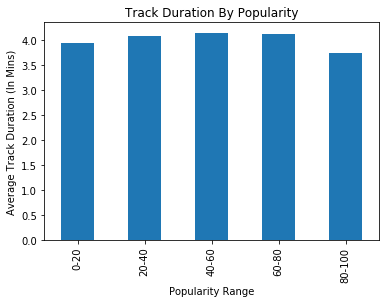

<Figure size 432x288 with 0 Axes>

In [12]:
# popularity of tracks vs track duration. To find are tracks with shorter duration are more popular?

Average_Track_Duration = filtered_tracks_group["Track Duration(In Mins)"].mean()
Track_chart = Average_Track_Duration.plot(kind="bar", title="Track Duration By Popularity")
Track_chart.set_xlabel("Popularity Range")
Track_chart.set_ylabel("Average Track Duration (In Mins)")
plt.savefig('Output_Charts/TrackFig1.png',bbox_inches='tight')
plt.show()
plt.tight_layout()


In [13]:
# Group the data by Release year decade bins
filtered_tracks_group = outlier_occupancy.groupby("Release Year Decade")
print("Are tracks getting shorter over decades? ")
filtered_tracks_group["Track Duration(In Mins)"].mean()


Are tracks getting shorter over decades? 


Release Year Decade
1920-30      3.875000
1930-40      2.843750
1940-50      3.062500
1950-60      3.700880
1960-70      3.617900
1970-80      4.196746
1980-90      4.342105
1990-2000    4.325401
2000-10      4.061249
2010-20      4.070603
Name: Track Duration(In Mins), dtype: float64

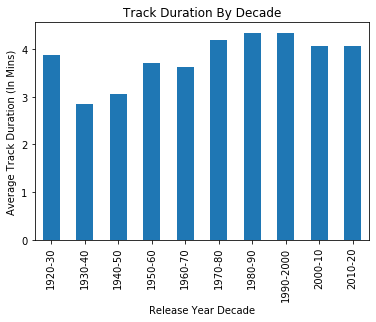

<Figure size 432x288 with 0 Axes>

In [14]:
# Create a Bar plot average Track duration for each decade to find if the average track duration is getting shorter over time

Average_Track_Duration = filtered_tracks_group["Track Duration(In Mins)"].mean()
Track_chart = Average_Track_Duration.plot(kind="bar", title="Track Duration By Decade")
Track_chart.set_xlabel("Release Year Decade")
Track_chart.set_ylabel("Average Track Duration (In Mins)")
plt.savefig('Output_Charts/TrackFig2.png',bbox_inches='tight')
plt.show()
plt.tight_layout()

In [15]:
# Retrieve most popular tracks data for past decade 
LastDecade_df = track_df.loc[(track_df["Release Year Decade"] == "2010-20") & (track_df["Popularity"] >  80 )]
LastDecade_df.reset_index(drop=True, inplace = True)

In [16]:
# Create a separate list of each feature value
x_axis = np.arange(1,28,1)
points_D = LastDecade_df["Danceability"]
points_E = LastDecade_df["Energy"]
points_k = LastDecade_df["Key"]
points_L = LastDecade_df["Loudness"]
points_M = LastDecade_df["Mode"]
points_S = LastDecade_df["Speechiness"]
points_A = LastDecade_df["Acousticness"]
points_I = LastDecade_df["Instrumentalness"]
points_Live = LastDecade_df["Liveness"]
points_V = LastDecade_df["Valence"]
points_T = LastDecade_df["Tempo"]

In [17]:
plt.style.use("bmh")
sns.set(style="darkgrid")

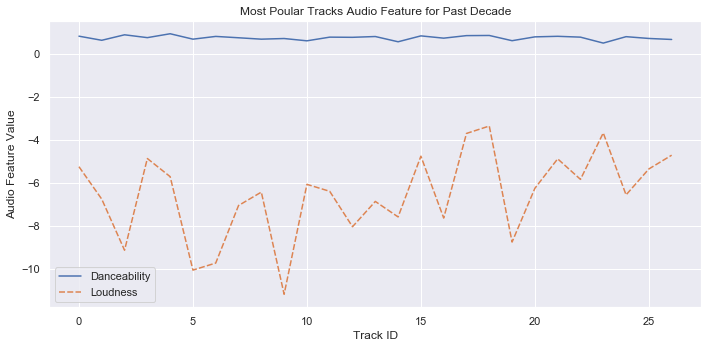

In [18]:
# Create line plot for Danceability/Loudness of tracks for past decade to see which feature makes the songs more popular
def correl_plot(cols):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10,5))
    sns.lineplot(data=LastDecade_df[cols])
    ax.set_title("Most Poular Tracks Audio Feature for Past Decade")
    ax.set_xlabel("Track ID")
    ax.set_ylabel("Audio Feature Value")
correl_plot([ "Danceability", "Loudness"])
plt.savefig('Output_Charts/TrackFig3.png',bbox_inches='tight')

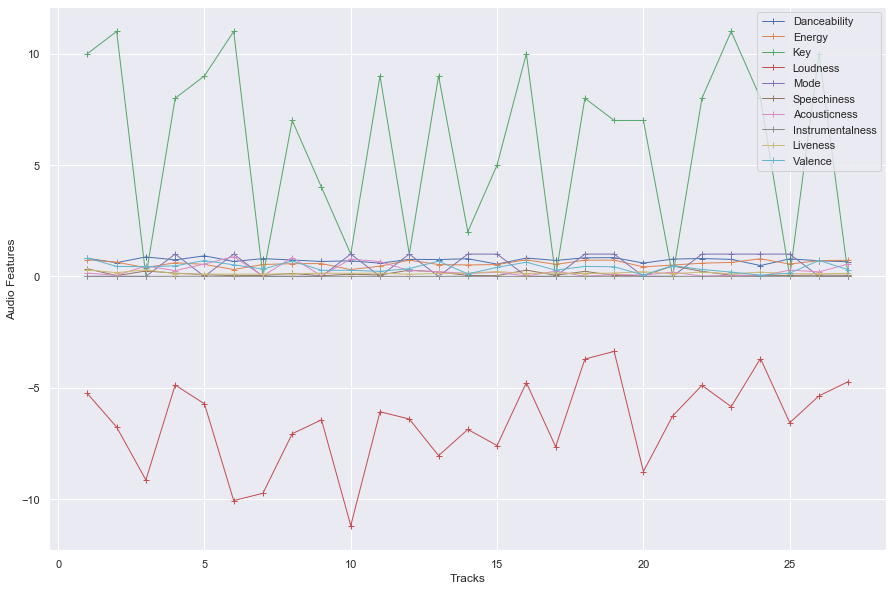

Variation in Key and Loudness feature made the songs popular in past decade


In [19]:
# Create line plot for each feature in same figure to see how the feature values differ for each popular track

plt.figure(figsize=(15,10))
plt.plot(x_axis, points_D, marker="+", linewidth=1, label="Danceability")
plt.plot(x_axis, points_E, marker="+", linewidth=1, label="Energy")
plt.plot(x_axis, points_k, marker="+", linewidth=1, label="Key")
plt.plot(x_axis, points_L, marker="+", linewidth=1, label="Loudness")
plt.plot(x_axis, points_M, marker="+", linewidth=1, label="Mode")
plt.plot(x_axis, points_S, marker="+", linewidth=1, label="Speechiness")
plt.plot(x_axis, points_A, marker="+", linewidth=1, label="Acousticness")
plt.plot(x_axis, points_I, marker="+", linewidth=1, label="Instrumentalness")
plt.plot(x_axis, points_Live, marker="+", linewidth=1, label="Liveness")
plt.plot(x_axis, points_V, marker="+", linewidth=1, label="Valence")
#plt.plot(x_axis, points_T, marker="+", linewidth=1, label="Tempo")


plt.legend(["Danceability", "Energy", "Key" , "Loudness", "Mode", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence"], loc="best")
plt.xlabel("Tracks")
plt.ylabel("Audio Features")
plt.savefig('Output_Charts/TrackFig4.png',bbox_inches='tight')
plt.show()

print("Variation in Key and Loudness feature made the songs popular in past decade")

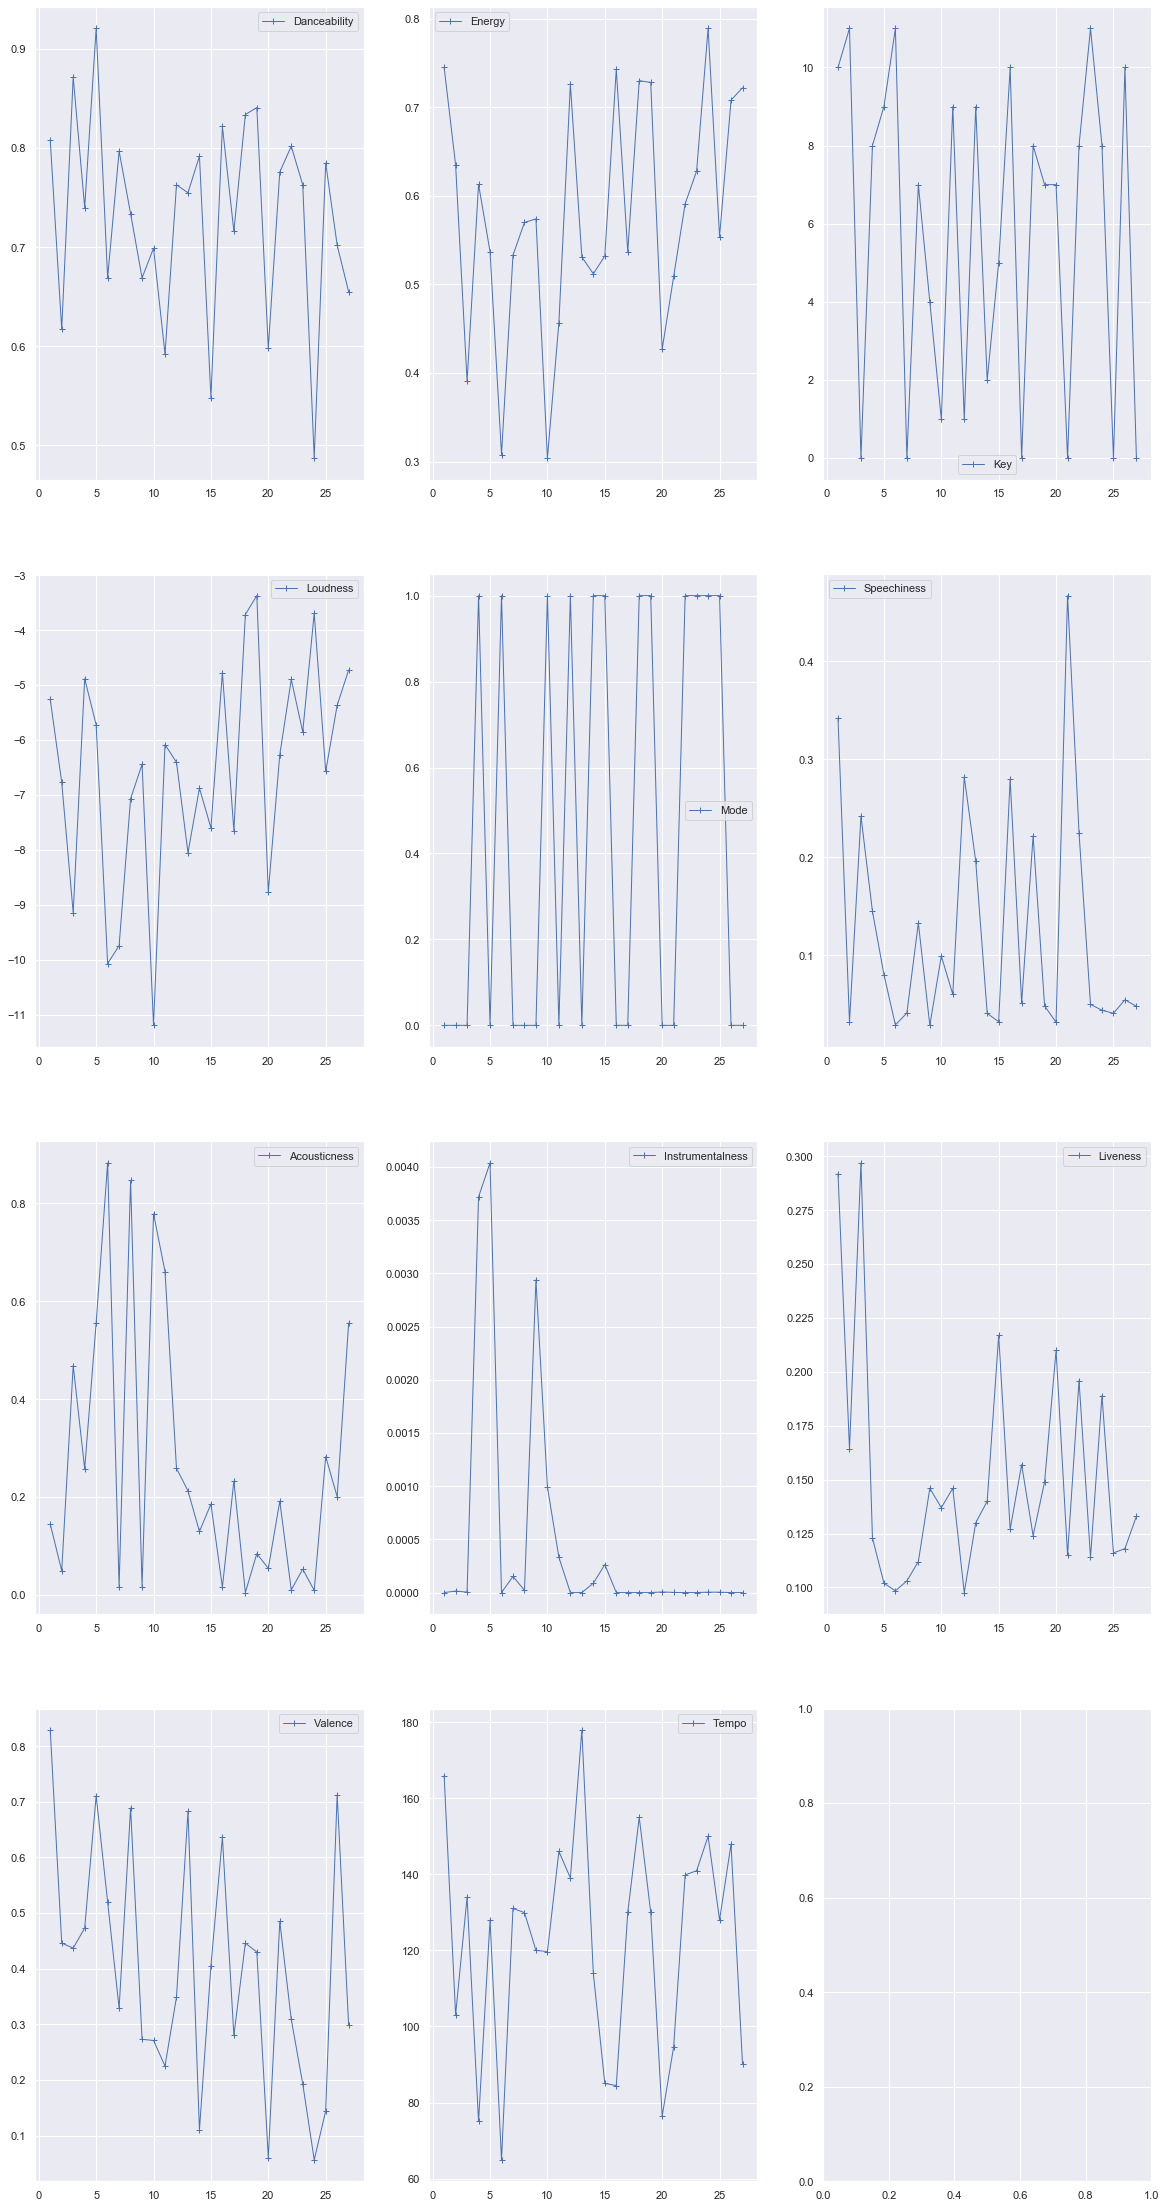

In [20]:
# Create separte plots for each feature 
# To see how the feature values differ for each popular track

fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(20, 40))

plt.subplot(4,3,1)
plt.plot(x_axis, points_D, marker="+", linewidth=1, label="Danceability")
plt.legend()

plt.subplot(4,3,2)
plt.plot(x_axis, points_E, marker="+", linewidth=1, label="Energy")
plt.legend()

plt.subplot(4,3,3)
plt.plot(x_axis, points_k, marker="+", linewidth=1, label="Key")
plt.legend()

plt.subplot(4,3,4)
plt.plot(x_axis, points_L, marker="+", linewidth=1, label="Loudness")
plt.legend()

plt.subplot(4,3,5)
plt.plot(x_axis, points_M, marker="+", linewidth=1, label="Mode")
plt.legend()

plt.subplot(4,3,6)
plt.plot(x_axis, points_S, marker="+", linewidth=1, label="Speechiness")
plt.legend()

plt.subplot(4,3,7)
plt.plot(x_axis, points_A, marker="+", linewidth=1, label="Acousticness")
plt.legend()


plt.subplot(4,3,8)
plt.plot(x_axis, points_I, marker="+", linewidth=1, label="Instrumentalness")
plt.legend()

plt.subplot(4,3,9)
plt.plot(x_axis, points_Live, marker="+", linewidth=1, label="Liveness")
plt.legend()

plt.subplot(4,3,10)
plt.plot(x_axis, points_V, marker="+", linewidth=1, label="Valence")
plt.legend()

plt.subplot(4,3,11)
plt.plot(x_axis, points_T, marker="+", linewidth=1, label="Tempo")
plt.legend()

#plt.savefig('Output_Charts/TrackFig5.png',bbox_inches='tight')

In [21]:
# Get all tracks for past decade
LastDecade_df = track_df.loc[(track_df["Release Year Decade"] == "2010-20")]
LastDecade_df.reset_index(drop=True, inplace = True)

In [22]:
# Get average of each audio feature of all tracks for past decade
filtered_last_decade = LastDecade_df[["Danceability", "Energy", "Key", "Mode" , "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence" , "Release Year Decade"]]
grouped_last_decade = filtered_last_decade.groupby("Release Year Decade").mean()
grouped_last_decade.dropna(inplace = True)
grouped_last_decade


,Danceability,Energy,Key,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
Release Year Decade,,,,,,,,,
2010-20,0.562815,0.605714,5.301768,0.640152,0.076897,0.325293,0.181057,0.207578,0.513213


In [23]:
# Create list of feature and values to use in seaborn bar chart
Features = []
Feature_Values = []
for (ColumnName, columnData) in grouped_last_decade.iteritems():
       #print('Colunm Name : ', ColumnName)
       #print('Column Contents : ', columnData.values)
       Features.append(ColumnName)
       Feature_Values.append(round(columnData.values[0], 6))
#print(Feature_Values)
#print(Features)
new_df = pd.DataFrame({"Feature" : Features, "Values" : Feature_Values})


In [24]:
plt.style.use("bmh")
sns.set(style="darkgrid")

<Figure size 720x360 with 0 Axes>

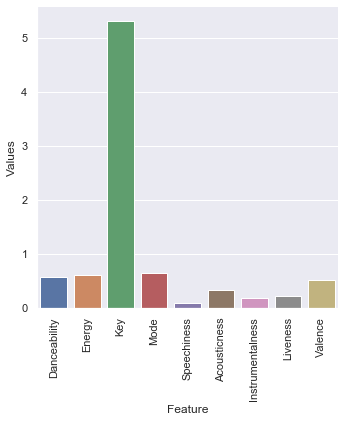

In [25]:
# Create a bar plot for  average value of each audio feature for all tracks in past decade to see how the audio fetaures used

fig = plt.figure(figsize=(10,5))
g = sns.catplot(x="Feature", y="Values", kind="bar", data=new_df)
g.set_xticklabels(rotation=90)
#g.set_title("Most Poular Tracks Audio Feature for Past Decade")
#g.set_xlabel("Track ID")
#g.set_ylabel("Audio Feature Value")
plt.savefig('Output_Charts/TrackFig6.png')
#plt.savefig('Output_Charts/TrackFig6.png',bbox_inches='tight')



In [26]:
#############Create bar plot for audio feature of all tracks for past 3 decades

In [46]:
LastDecade_df = track_df.loc[(track_df["Release Year Decade"] == "2010-20") | (track_df["Release Year Decade"] == "2000-10") | (track_df["Release Year Decade"] == "1990-2000")]
LastDecade_df.reset_index(drop=True, inplace = True)
filtered_last_decade = LastDecade_df[["Danceability", "Energy", "Key", "Mode" , "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence" , "Release Year Decade"]]
grouped_last_decade = filtered_last_decade.groupby("Release Year Decade").mean()
grouped_last_decade.dropna(inplace = True)
grouped_last_decade


,Danceability,Energy,Key,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
Release Year Decade,,,,,,,,,
1990-2000,0.566737,0.599650,5.391885,0.686697,0.081962,0.273931,0.147030,0.199908,0.530847
2000-10,0.555423,0.651805,5.300351,0.682084,0.076928,0.289096,0.123116,0.203050,0.551285
2010-20,0.562815,0.605714,5.301768,0.640152,0.076897,0.325293,0.181057,0.207578,0.513213


In [47]:
Decade = []
Features = []
Feature_Values = []
for name in grouped_last_decade.index:
    for (ColumnName, columnData) in grouped_last_decade.iteritems():
        Features.append(ColumnName)
        Feature_Values.append(round(columnData.values[0], 6))
        Decade.append(name)
#print(Feature_Values)
#print(Features)
#print(Decade)
new_df = pd.DataFrame({"Feature" : Features, "Values" : Feature_Values, "Decade" : Decade})
       
       
        
        
        

In [48]:
plt.style.use("bmh")
sns.set(style="darkgrid")

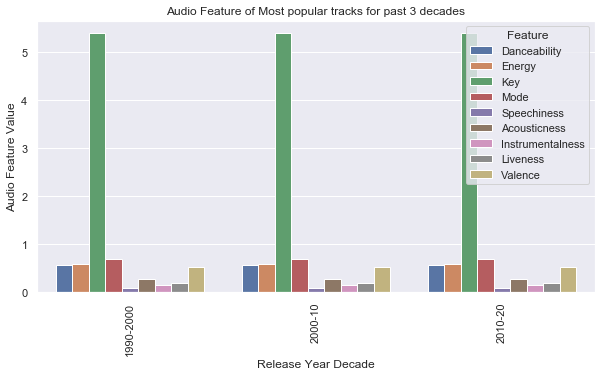

In [49]:
# Create bar plot for audio feature of all tracks for past 3 decades to see how the values change with each decade
plt.figure(figsize=(10,5))
#g = sns.catplot(x="Feature", y="Values", kind="bar", data=new_df)
g=sns.barplot(x='Decade', y='Values', hue='Feature', data=new_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("Audio Feature of Most popular tracks for past 3 decades")
g.set_xlabel("Release Year Decade")
g.set_ylabel("Audio Feature Value")
plt.savefig('Output_Charts/TrackFig7.png')





In [105]:
#### Compare features of Popular songs vs non popular songs for last decade

In [106]:
# get popular songs for last decade
LastDecade_popular_df = track_df.loc[(track_df["Release Year Decade"] == "2010-20") & (track_df["Popularity"] >  80 )]
LastDecade_popular_df.reset_index(drop=True, inplace = True)
filtered_popular_last_decade = LastDecade_popular_df[["Danceability", "Energy", "Key", "Mode" , "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence" , "Release Year Decade"]]
grouped_popular_last_decade = filtered_popular_last_decade.groupby("Release Year Decade").mean()
grouped_popular_last_decade.dropna(inplace = True)
grouped_popular_last_decade


,Danceability,Energy,Key,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
Release Year Decade,,,,,,,,,
2010-20,0.731741,0.579037,5.777778,0.444444,0.123952,0.265515,0.000466,0.150111,0.400033


In [107]:
# get non popular songs for last decade
LastDecade_nonpopular_df = track_df.loc[(track_df["Release Year Decade"] == "2010-20") & (track_df["Popularity"] <=  80 )]
LastDecade_nonpopular_df.reset_index(drop=True, inplace = True)
filtered_Nonpopular_last_decade = LastDecade_nonpopular_df[["Danceability", "Energy", "Key", "Mode" , "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence" , "Release Year Decade"]]
grouped_nonpopular_last_decade = filtered_Nonpopular_last_decade.groupby("Release Year Decade").mean()
grouped_nonpopular_last_decade.dropna(inplace = True)
grouped_nonpopular_last_decade


,Danceability,Energy,Key,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
Release Year Decade,,,,,,,,,
2010-20,0.559886,0.606176,5.293513,0.643545,0.076081,0.326329,0.184189,0.208575,0.515176


In [108]:
# creating lists to merge popular and non popular features and values into 1 list to use for seaborn
Type = []
Features = []
Feature_Values = []
for name in grouped_popular_last_decade.index:
    for (ColumnName, columnData) in grouped_popular_last_decade.iteritems():
        Features.append(ColumnName)
        Feature_Values.append(round(columnData.values[0], 6))
        Type.append("Popular_2010-20")
        
for name in grouped_nonpopular_last_decade.index:
    for (ColumnName, columnData) in grouped_nonpopular_last_decade.iteritems():
        Features.append(ColumnName)
        Feature_Values.append(round(columnData.values[0], 6))
        Type.append("NonPopular_2010-20")
new_df = pd.DataFrame({"Feature" : Features, "Values" : Feature_Values, "Type" : Type}) 
        
        

# There was a huge difference in Danceability and Key value for popular vs non popular songs of same decade


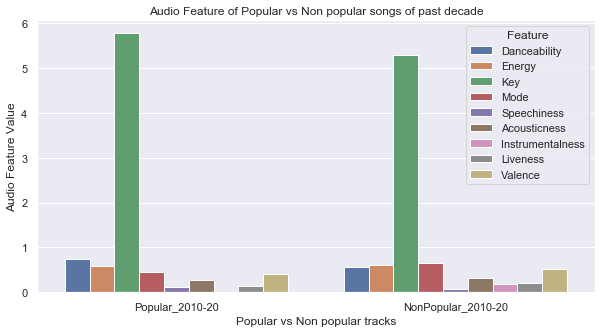

In [109]:
plt.style.use("bmh")
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
#g = sns.catplot(x="Feature", y="Values", kind="bar", data=new_df)
g=sns.barplot(x='Type', y='Values', hue='Feature', data=new_df)
#g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("Audio Feature of Popular vs Non popular songs of past decade")
g.set_xlabel("Popular vs Non popular tracks")
g.set_ylabel("Audio Feature Value")
plt.savefig('Output_Charts/TrackFig8.png')
print("# There was a huge difference in Danceability and Key value for popular vs non popular songs of same decade")


In [110]:
#### Compare features of Popular songs vs non popular songs for last 3  decades

In [118]:
# get popular songs for last decade
LastDecade_popular_df = track_df.loc[((track_df["Release Year Decade"] == "2010-20") | (track_df["Release Year Decade"] == "1990-2000") | (track_df["Release Year Decade"] == "2000-10")) & (track_df["Popularity"] >  80 )]
LastDecade_popular_df.reset_index(drop=True, inplace = True)
filtered_popular_last_decade = LastDecade_popular_df[["Danceability", "Energy", "Key", "Mode" , "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence" , "Release Year Decade"]]
grouped_popular_last_decade = filtered_popular_last_decade.groupby("Release Year Decade").mean()
grouped_popular_last_decade.dropna(inplace = True)


# get non popular songs for last decade
LastDecade_nonpopular_df = track_df.loc[((track_df["Release Year Decade"] == "2010-20") | (track_df["Release Year Decade"] == "1990-2000") | (track_df["Release Year Decade"] == "2000-10")) & (track_df["Popularity"] <=  80 )]
LastDecade_nonpopular_df.reset_index(drop=True, inplace = True)
filtered_Nonpopular_last_decade = LastDecade_nonpopular_df[["Danceability", "Energy", "Key", "Mode" , "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence" , "Release Year Decade"]]
grouped_nonpopular_last_decade = filtered_Nonpopular_last_decade.groupby("Release Year Decade").mean()
grouped_nonpopular_last_decade.dropna(inplace = True)



In [119]:
grouped_popular_last_decade

,Danceability,Energy,Key,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
Release Year Decade,,,,,,,,,
1990-2000,0.568000,0.595333,8.000000,0.666667,0.037783,0.052798,0.000338,0.187950,0.394167
2000-10,0.632000,0.667500,5.333333,1.000000,0.120317,0.200903,0.000718,0.279100,0.418500
2010-20,0.731741,0.579037,5.777778,0.444444,0.123952,0.265515,0.000466,0.150111,0.400033


In [120]:
grouped_nonpopular_last_decade

,Danceability,Energy,Key,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
Release Year Decade,,,,,,,,,
1990-2000,0.566734,0.599663,5.383823,0.686759,0.082099,0.274615,0.147483,0.199945,0.531270
2000-10,0.555153,0.651750,5.300235,0.680964,0.076775,0.289406,0.123548,0.202781,0.551753
2010-20,0.559886,0.606176,5.293513,0.643545,0.076081,0.326329,0.184189,0.208575,0.515176


In [121]:
# creating lists to merge popular and non popular features and values into 1 list to use for seaborn
Decade = []
Type = []
Features = []
Feature_Values = []
for name in grouped_popular_last_decade.index:
    for (ColumnName, columnData) in grouped_popular_last_decade.iteritems():
        Features.append(ColumnName)
        Feature_Values.append(round(columnData.values[0], 6))
        type = "Popular_" + name 
        Type.append(type)
        Decade.append(name)
    for (ColumnName, columnData) in grouped_nonpopular_last_decade.iteritems():
        Features.append(ColumnName)
        Feature_Values.append(round(columnData.values[0], 6))
        type = "NonPopular_" + name 
        Type.append(type)
        Decade.append(name)
        


In [122]:
new_df = pd.DataFrame({"Feature" : Features, "Values" : Feature_Values, "Type" : Type, "Decade"  : Decade}) 

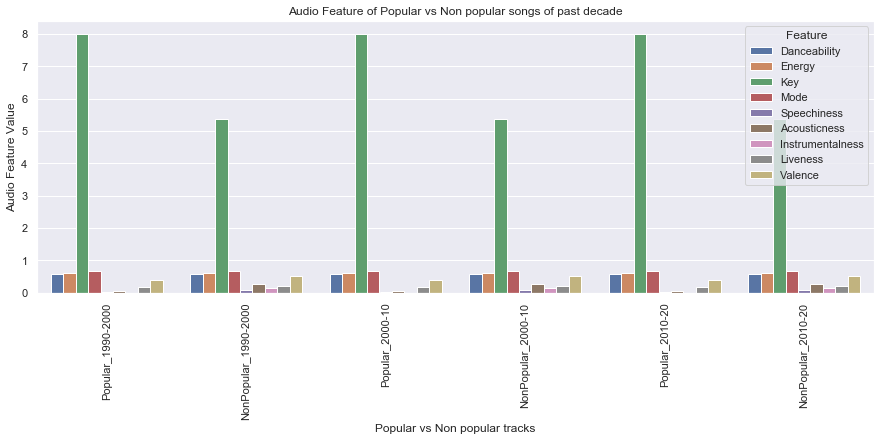

In [123]:
plt.style.use("bmh")
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
#g = sns.catplot(x="Feature", y="Values", kind="bar", data=new_df)
g=sns.barplot(x='Type', y='Values', hue='Feature', data=new_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("Audio Feature of Popular vs Non popular songs of past decade")
g.set_xlabel("Popular vs Non popular tracks")
g.set_ylabel("Audio Feature Value")
plt.savefig('Output_Charts/TrackFig9.png')
